# Minimum Vertex Cover (MVC) Problem
Given an undirected graph $G(V,E)$, find the smallest set of vertices s.t. the set covers the graph (each edge is incident to at least one vertex in the cover set

Solve using DWave's QUBO formulation tools on a direct QPU solver

In [8]:
# import necessary packages
import time
import numpy as np
import numpy.random as random

import dimod
import networkx as nx

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import LazyEmbeddingComposite
from pyqubo import Binary

## Funtion for solving/sampling QUBO
Given a hamiltonian $H$ in QUBO form, solve for the lowest energy solution

In [2]:
def qdict_to_matrix(qubo,qubits):
    Q = np.zeros([len(qubits),len(qubits)])
    for (i,j) in qubo:
        x = int(i[1:])
        y = int(j[1:])
        Q[x,y] = qubo[(i,j)]
    return Q

def solve_qubo(H,
               qubits,
               sampler="CPU", # CPU or QPU
               k=10,
               chain_strength=None):
    """
    Given a hamiltonian, solves the quadratic unconstrained binary
    optimization (QUBO) problem given by
    
        minimize sum(x[i] * Q[i,j] * x[j]
                     for i in range(N),
                     for j in range(i+1, N))
    
    Uses compile() to convert the hamiltonian into matrix (dictionary) form.
    dimod.SimulatedAnnealingSampler is then used, which solves the problem k times through simulated
    annealing (on a regular CPU). This method returns the best solution found.
    """
    assert sampler in ["CPU", "QPU"]
    
    model = H.compile()
    qubo, offset = model.to_qubo()
    bqm = dimod.BinaryQuadraticModel.from_qubo(qubo,offset=offset)
    
    Q = qdict_to_matrix(qubo,qubits)
    n = Q.shape[0]
    nz = len(Q[Q!=0])
    print("Solving QUBO problem (%d vars, %d nz) on %s..." % (n, nz, sampler))
    
    start = time.time()
    
    if sampler == "CPU":
        sampler = dimod.SimulatedAnnealingSampler()
        response = sampler.sample(bqm, num_reads=k)
    else:
        if chain_strength is None:
            chain_strength = int(10 * max(qubo.values()))
        sampler = LazyEmbeddingComposite(DWaveSampler(solver="Advantage_system6.1"))
        response = sampler.sample(bqm, num_reads=k, chain_strength=chain_strength)
        
    elapsed = time.time() - start
    
    print("Solved in %.2f seconds" % elapsed)
    solution = min(response.data(["sample", "energy"]), key=lambda s: s.energy)
    return solution, response, Q

## Generate random graph

60


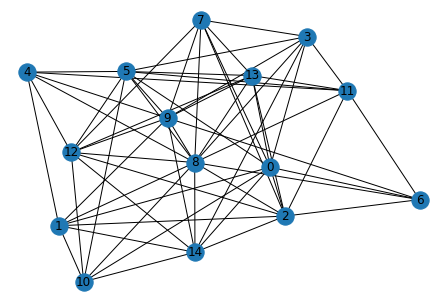

In [49]:
# number of nodes
n = 15
# edge generation probability
p = 0.6
# seed (optional)
seed = 30
# generate graph
graph = nx.gnp_random_graph(n,p,seed)

# draw graph
nx.draw(graph, with_labels=True)

print(len(graph.edges))

## Define Hamitonian
Objective funtion: min$y=\sum_{i\in V}x_i+P(\sum_{(i,j)}(1-x_i-x_j+x_ix_j)$

In [50]:
# penalty value
P = 8

H = 0
x = []
for i in graph.nodes:
    x.append(Binary(f'x{i}'))
    H += x[i]
    
for (i,j) in graph.edges:
    H += P*(1-x[i]-x[j]+x[i]*x[j])

## Solve on CPU

In [51]:
k=10
# solve problem
solution1, response1, Q = solve_qubo(H,x,"CPU",k)

# display result
print(response1)

Solving QUBO problem (15 vars, 75 nz) on CPU...
Solved in 0.99 seconds
  x0 x1 x10 x11 x12 x13 x14 x2 x3 x4 x5 x6 x7 x8 x9 energy num_oc.
4  1  1   0   1   1   0   1  1  0  0  1  0  1  1  1   10.0       1
6  1  1   0   1   1   0   1  1  0  0  1  0  1  1  1   10.0       1
8  1  1   0   1   1   0   1  1  0  0  1  0  1  1  1   10.0       1
0  1  1   0   1   1   1   1  0  0  0  1  1  1  1  1   11.0       1
1  1  1   1   1   1   0   0  1  1  0  1  0  1  1  1   11.0       1
2  1  1   0   1   1   1   1  0  0  0  1  1  1  1  1   11.0       1
3  1  0   1   1   0   1   1  1  0  1  1  0  1  1  1   11.0       1
7  1  0   1   1   1   1   1  1  1  1  0  0  0  1  1   11.0       1
9  1  0   1   1   1   0   1  1  0  1  1  0  1  1  1   11.0       1
5  0  1   1   0   1   1   1  1  1  1  1  1  1  1  0   12.0       1
['BINARY', 10 rows, 10 samples, 15 variables]


In [53]:
print(solution1)

Sample(sample={'x0': 1, 'x1': 1, 'x10': 0, 'x11': 1, 'x12': 1, 'x13': 0, 'x14': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 1, 'x6': 0, 'x7': 1, 'x8': 1, 'x9': 1}, energy=10.0)


## Recolor graph to show solution
red vertices in cover set

size of cover:  10.0


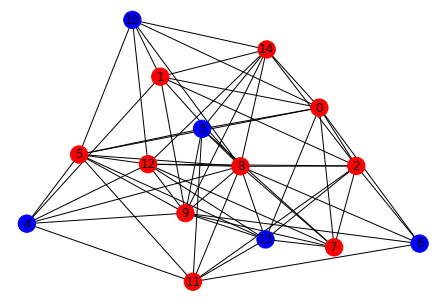

In [55]:
# assign colors
color_map = []
for node in graph:
    if solution1.sample[f'x{node}'] < 0.5:
        color_map.append('blue')
    else: 
        color_map.append('red')
        
nx.draw(graph, node_color=color_map, with_labels=True)

print("size of cover: ", solution1.energy)

## Solve on QPU

In [56]:
k=2000
# solve problem
solution, response, Q = solve_qubo(H,x,"QPU",k)

# display result
print(response)

Solving QUBO problem (15 vars, 75 nz) on QPU...
Solved in 2.27 seconds
     x0 x1 x10 x11 x12 x13 x14 x2 x3 x4 x5 x6 x7 x8 x9 energy num_oc. ...
0     1  1   0   1   1   0   1  1  0  0  1  0  1  1  1   10.0       1 ...
1     1  1   1   1   1   1   0  1  1  1  0  0  0  1  1   11.0       5 ...
2     1  1   1   1   1   0   1  1  0  0  1  0  1  1  1   11.0       1 ...
3     1  1   0   1   1   0   1  1  1  0  1  0  1  1  1   11.0       2 ...
4     1  0   1   1   1   1   1  1  1  1  0  0  0  1  1   11.0       3 ...
5     1  1   0   1   1   0   1  1  0  0  1  1  1  1  1   11.0       1 ...
6     1  1   1   1   1   0   0  1  1  0  1  0  1  1  1   11.0       3 ...
7     1  1   1   1   1   1   0  1  1  0  1  0  0  1  1   11.0       4 ...
8     1  1   0   1   1   1   1  0  0  0  1  1  1  1  1   11.0       1 ...
9     1  1   0   1   1   1   1  1  1  0  1  0  0  1  1   11.0       1 ...
10    1  1   0   1   1   0   1  1  0  1  1  0  1  1  1   11.0       2 ...
11    1  1   1   1   1   0   1  1  0  0  

In [57]:
print(solution)

Sample(sample={'x0': 1, 'x1': 1, 'x10': 0, 'x11': 1, 'x12': 1, 'x13': 0, 'x14': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 1, 'x6': 0, 'x7': 1, 'x8': 1, 'x9': 1}, energy=10.0)


## Recolor graph to show solution

size of cover:  10.0


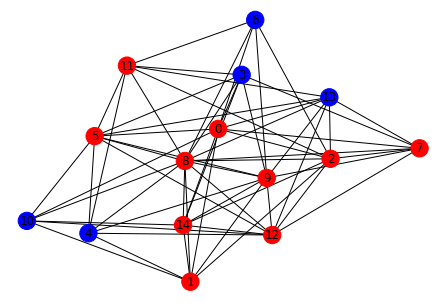

In [58]:
# assign colors
color_map = []
for node in graph:
    if solution.sample[f'x{node}'] < 0.5:
        color_map.append('blue')
    else: 
        color_map.append('red')
        
nx.draw(graph, node_color=color_map, with_labels=True)

print("size of cover: ", solution.energy)